# Forest fire prediction and prevention

Forest fire can be large scale natural disasters and have a great impact on the environment. Early warning and detection can help prevent these 
events, and machine learning models can be helpful in achieving this.

![Forest fire](https://gdb.voanews.com/054f5cb3-1868-4b15-a6a8-7e5717759c0f_w1200_r1.jpg)

In this notebook I will use the [Algerian Forest Fires Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++) to test 
different types of machine learning models in order to see if it is possible to predict forest fires. 

Data Set Information:

The dataset includes 244 instances that regroup a data of two regions of Algeria,namely the Bejaia region located in the northeast of Algeria and the Sidi Bel-abbes region located in the northwest of Algeria.

122 instances for each region.

The period from June 2012 to September 2012.
The dataset includes 11 attribues and 1 output attribue (class)
The 244 instances have been classified into fire (138 classes) and not fire (106 classes) classes.


Attribute Information:

1. Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012)
Weather data observations
2. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
3. RH : Relative Humidity in %: 21 to 90
4. Ws :Wind speed in km/h: 6 to 29
5. Rain: total day in mm: 0 to 16.8
FWI Components
6. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
7. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
8. Drought Code (DC) index from the FWI system: 7 to 220.4
9. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
10. Buildup Index (BUI) index from the FWI system: 1.1 to 68
11. Fire Weather Index (FWI) Index: 0 to 31.1
12. Classes: two classes, namely fire and not fire

# Setup and Importing libraries

In [210]:
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import plotly.express as px

# import scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier # you may need to install XGBoost
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from yellowbrick.model_selection import learning_curve

# helpers
import sys
sys.path.append(r"C:\Users\terje\DataspellProjects\tub_advanced_ds")
from src.helpers import feature_importance_plot
from src.helper_classes import EDA, Model

sns.set(rc={"figure.figsize": (20,10)})

# EDA

In order to train and test our machine learning model we'll first need to get a better understanding and overview of our data. 
In this section I'll perform an exploratory data analysis.

As we have two variables that indicate forest fire in our dataset, *FWI* and *Classes* I will create models using each as the target variable

In [211]:
# Using the EDA helper class to load data
forest_fires_fwi = EDA("../data/algerian_forest_fires.csv")
forest_fires_classes = EDA("../data/algerian_forest_fires.csv")

In [212]:
# Set target variables for both FWI (continious) and for Classes (categorical)
forest_fires_fwi.target("FWI", target_type="cont")
forest_fires_classes.target("Classes", target_type="cat")

## Exploring the data

In this section we'll examine our data with a focus on identifying potential issues for our models.

### Feature columns

We'll start by looking at the complete dataset and examine the features looking at some descriptive statistics and information.

In [213]:
forest_fires_fwi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  Classes      243 non-null    object 
dtypes: float64(6), int64(6), object(1)
memory usage: 24.8+ KB


We see that we have 243 rows and none of the 13 columns with missing data. All our columns are numerical with a mix of ints and floats expect for our target column *Classes*

In [214]:
forest_fires_fwi.df.sample(10)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
146,25,6,2012,34,70,16,0.0,86.0,12.8,25.6,5.4,12.7,6.7,fire
17,18,6,2012,31,78,14,0.3,56.9,1.9,8.0,0.7,2.4,0.2,not fire
100,9,9,2012,30,77,15,1.0,56.1,2.1,8.4,0.7,2.6,0.2,not fire
123,2,6,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
138,17,6,2012,31,69,17,4.7,62.2,3.9,8.0,1.1,3.8,0.4,not fire
56,27,7,2012,36,48,13,0.0,90.3,22.2,108.5,8.7,29.4,15.3,fire
79,19,8,2012,35,62,19,0.0,89.4,23.2,120.9,9.7,31.3,17.2,fire
27,28,6,2012,32,55,14,0.0,89.1,25.5,88.5,7.6,29.7,13.9,fire
45,16,7,2012,28,76,21,0.0,72.6,7.0,25.5,0.7,8.3,0.4,not fire
21,22,6,2012,31,67,17,0.1,79.1,7.0,39.5,2.4,9.7,2.3,not fire


From sampling 10 rows we see that fires occured with a FWI as low as 7.5. We'll investigate this a bit further by checking the FWI
for only days with fire.

In [215]:
forest_fires_fwi.df[forest_fires_fwi.df["Classes"] == "fire"].sort_values("FWI")

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
96,5,9,2012,29,75,16,0.0,80.8,3.4,24.0,2.8,5.1,1.7,fire
20,21,6,2012,30,78,14,0.0,81.0,6.3,31.6,2.6,8.4,2.2,fire
5,6,6,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire
215,3,9,2012,28,75,16,0.0,82.2,4.4,24.3,3.3,6.0,2.5,fire
220,8,9,2012,30,88,14,0.0,82.5,6.6,26.1,3.0,8.1,2.7,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,24,8,2012,35,38,15,0.0,92.1,51.3,147.7,12.2,54.9,26.9,fire
171,21,7,2012,36,29,18,0.0,93.9,39.6,80.6,18.5,39.5,30.0,fire
89,29,8,2012,35,48,18,0.0,90.1,54.2,220.4,12.5,67.4,30.2,fire
207,26,8,2012,33,37,16,0.0,92.2,61.3,167.2,13.1,64.0,30.3,fire


Looking at the days where there was a fire we see that fires took place with the FWI being as low as 1.7.

In [216]:
forest_fires_fwi.describe()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
count,243.000000,243.000000,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fire
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137
mean,15.761317,7.502058,2012.0,32.152263,62.041152,15.493827,0.762963,77.842387,14.680658,49.430864,4.742387,16.690535,NaN
std,8.842552,1.114793,0.0,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,47.665606,4.154234,14.228421,NaN
min,1.000000,6.000000,2012.0,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,NaN
25%,8.000000,7.000000,2012.0,30.000000,52.500000,14.000000,0.000000,71.850000,5.800000,12.350000,1.400000,6.000000,NaN
50%,16.000000,8.000000,2012.0,32.000000,63.000000,15.000000,0.000000,83.300000,11.300000,33.100000,3.500000,12.400000,NaN
75%,23.000000,8.000000,2012.0,35.000000,73.500000,17.000000,0.500000,88.300000,20.800000,69.100000,7.250000,22.650000,NaN


These are the key descirptives:

- All our data is from 2012 and from the months between June and September.
- The average temperature in these months was 32 degrees, with the min being 22 and max 42.
- The average amount of rain is very low with an average of 0.8 mm per day. It appears most of the rain came on the same day.
- The average FWI was 7, with 75% of days having a FWI lower than 11.5

Seeing as out year column is static, we'll remove it.

In [217]:
# Check variance for all cols
forest_fires_fwi.df.std().round(2)

day             8.84
month           1.11
year            0.00
Temperature     3.63
RH             14.83
Ws              2.81
Rain            2.00
FFMC           14.35
DMC            12.39
DC             47.67
ISI             4.15
BUI            14.23
FWI             7.44
dtype: float64

In [218]:
# Remove low variance cols for both fwi and classes instances
forest_fires_fwi.remove_low_variance_cols(threshhold=0.1)

year    0.0
dtype: float64
Removed columns 'year' having variance below 0.1


,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,not fire
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,not fire
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,not fire
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,not fire
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,not fire
...,...,...,...,...,...,...,...,...,...,...,...,...
238,26,9,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,fire
239,27,9,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,not fire
240,28,9,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,not fire
241,29,9,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,not fire


In [219]:
forest_fires_classes.remove_low_variance_cols(threshhold=0.1)


year    0.0
dtype: float64
Removed columns 'year' having variance below 0.1


,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
238,26,9,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5
239,27,9,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0
240,28,9,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2
241,29,9,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7


Using a boxplot we can get a better understanding of the distribution of our data.

In [220]:
# Map months to month names
months = {"6": "June", "7": "July", "8": "August", "9": "September"}

fig = px.box(forest_fires_fwi.df_clean.drop(columns="Classes"), color="month", 
    title="Boxplot of features")
# Loop over traces and update plot with name from months mapping
fig.for_each_trace(lambda t: t.update(name = months[t.name],
                                      legendgroup = months[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, months[t.name])
                                     )
                  )

We see that there are relatively few outliers in our features. Moreover we see that the ranges are relatively uniform between features, except for DC during september.

In [221]:
px.imshow(forest_fires_fwi.correlations(), text_auto=True, aspect="auto", width=1000, height=600)

<div class="alert alert-block alert-info">
From the correlations plot we see that FFMC, DMC, DC, ISI, BUI and FWI are highly correlated. Since all of these are components of the FWI this makes sense. 
Using these as predictiors for a forest fire might be problematic, however.
</div>

>[!NOTE]
>The publisher will not get notified of the SaaS purchase until the customer initiates the configuration process from Microsoft side.

### Target columns

Next we'll examine our target columns, FWI and Classes.

#### FWI

FWI is hte Fire Weather Index and ranges from 0-31.1. It is based on midday air temperatures, relative air humidity and wind speeds as well as 24-hour precipitation rates [NWCG.gov](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system). The higher the index the more likely a fire is to occur. The FWI integrates Initial Spread Index (ISI) and BUI (Buildup Index) so these should be highly correlated.

We'll start by looking at the distribution of the FWI.

In [222]:
# Using the EDA class plot_target method to show distribution
forest_fires_fwi.plot_target()

We see that the distribution of the FWI is right skewed. This makes sense as forest fires are usually not frequent phenomena. 

### Classes

The Classes variable is a binary variable specifying if there was a fire or not. As such, it is a more clear cut predictor than FWI. It is therefore interesting to analyse both, and particularly the correlation between FWI and classes.

We'll start by looking at the distribution and then check the correlation between FWI and Classes.

In [223]:
forest_fires_classes.plot_target()

We see that the distribution between fire and non fire events are relatively balanced. 

Next we'll investigate the correlation between FWI and Classes

In [224]:
#forest_fires_classes.df["Classes_dummy"] = forest_fires_classes.df["Classes"].replace({"fire": 1, "not fire": 0})
forest_fires_classes.df["target_dummy"]

0      0
1      0
2      0
3      0
4      0
      ..
238    1
239    0
240    0
241    0
242    0
Name: target_dummy, Length: 243, dtype: int64

In [225]:
#forest_fires_classes.plot_target_corr(cols=["FWI"])
px.imshow(forest_fires_classes.df[["FWI", "target_dummy"]].corr(), text_auto=True)

We see that as expected FWI and Classes are highly positively correlated.

For our model we'll therefore drop FWI in the features for the Classes model and vice versa.

In [226]:
forest_fires_fwi.df_clean = forest_fires_fwi.df_clean.drop(columns="Classes")
forest_fires_fwi.df_clean

,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9
...,...,...,...,...,...,...,...,...,...,...,...
238,26,9,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9
239,27,9,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2
240,28,9,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4
241,29,9,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1


In [227]:
forest_fires_classes.df_clean = forest_fires_classes.df_clean.drop(columns="FWI")

# Modelling
Having explored and prepared our dataset, we are ready to train and evaluate our models.

We'll start by the models with FWI as target.

## FWI

For the FWI we'll be using regression with a DecisionTree a RandomForest and a XGB Regressor.

We'll use the Model class to create an instance of each model, and then fit and evaluate each and output their scores and feature importances.

In [228]:
fwi_models = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()]
fwi_fitted_models = {}
fwi_feature_importances = {}
fwi_model_scores = pd.DataFrame(index=["R2", "MAE", "MSE"])

for model in fwi_models:
    m = Model(forest_fires_fwi.target_var, forest_fires_fwi.df_clean, model)
    m.evaluate_model(type="reg", plot_learning_curve=False)
    fwi_fitted_models[m.model_name] = m
    fwi_feature_importances[m.model_name] = m.model.feature_importances_
    fwi_model_scores = pd.merge(fwi_model_scores, m.scores, left_index=True, right_index=True)

X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [7.3 6.  0.4 2.8 6. ]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.91
Mean Absolute Error: 1.0
Mean Squared Error: 3.0
X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [8.203 6.865 0.443 3.181 7.307]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.98
Mean Absolute Error: 1.0
Mean Squared Error: 1.0
X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [8.7736     7.126644   0.44291255 2.8076615  7.5889044 ]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.97
Mean Absolute Error: 1.0
Mean Squared Error: 1.0


In [229]:
fwi_model_scores.sort_index(ascending=False)

,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor
R2,0.906492,0.975433,0.971644
MSE,2.834082,0.744580,0.859412
MAE,0.944898,0.552551,0.534318


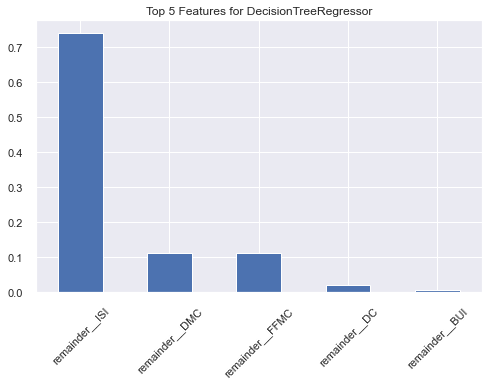

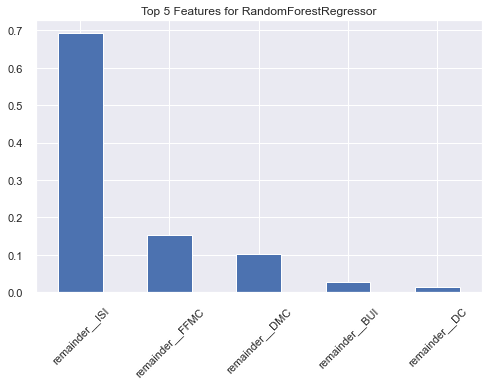

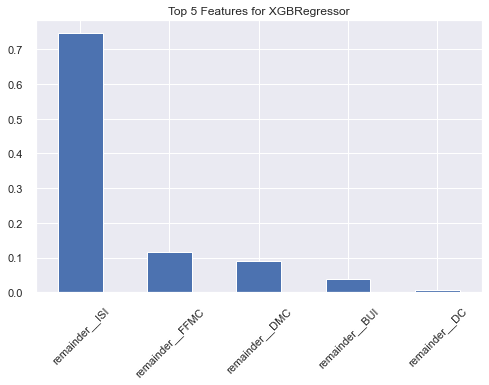

In [230]:
for model in fwi_fitted_models.values():
    model.feature_importance_plot()

Let's have a look at the learning curve for our best model the XGBRegressor.

X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [8.7736     7.126644   0.44291255 2.8076615  7.5889044 ]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.97
Mean Absolute Error: 1.0
Mean Squared Error: 1.0
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'num_parallel_tree', 'predictor', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'ra

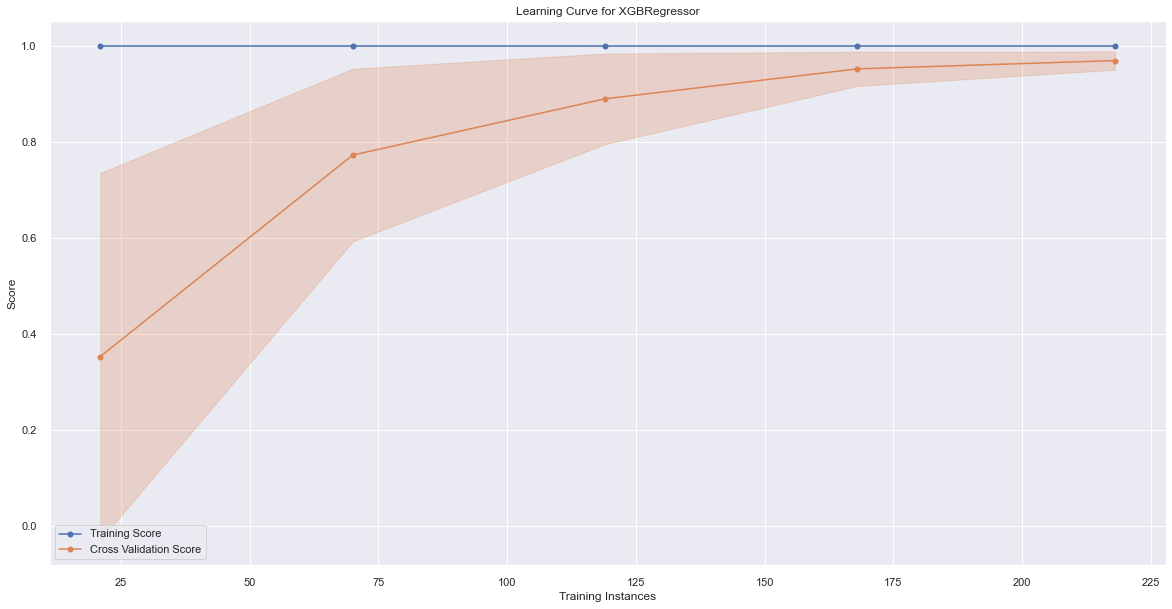

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'num_parallel_tree', 'predictor', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth'

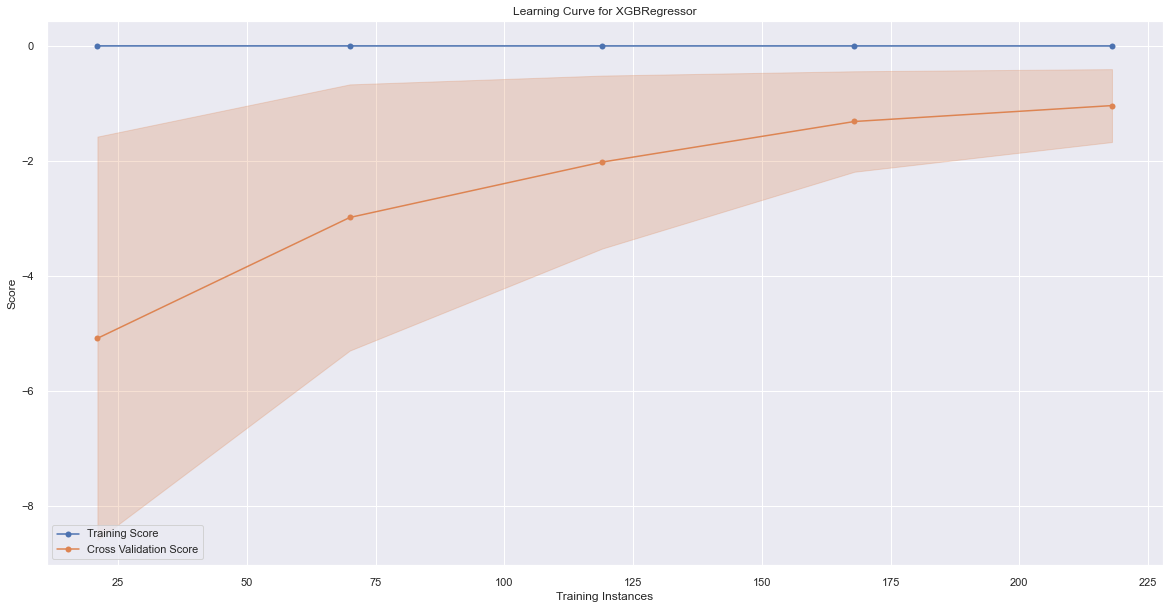

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'num_parallel_tree', 'predictor', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth'

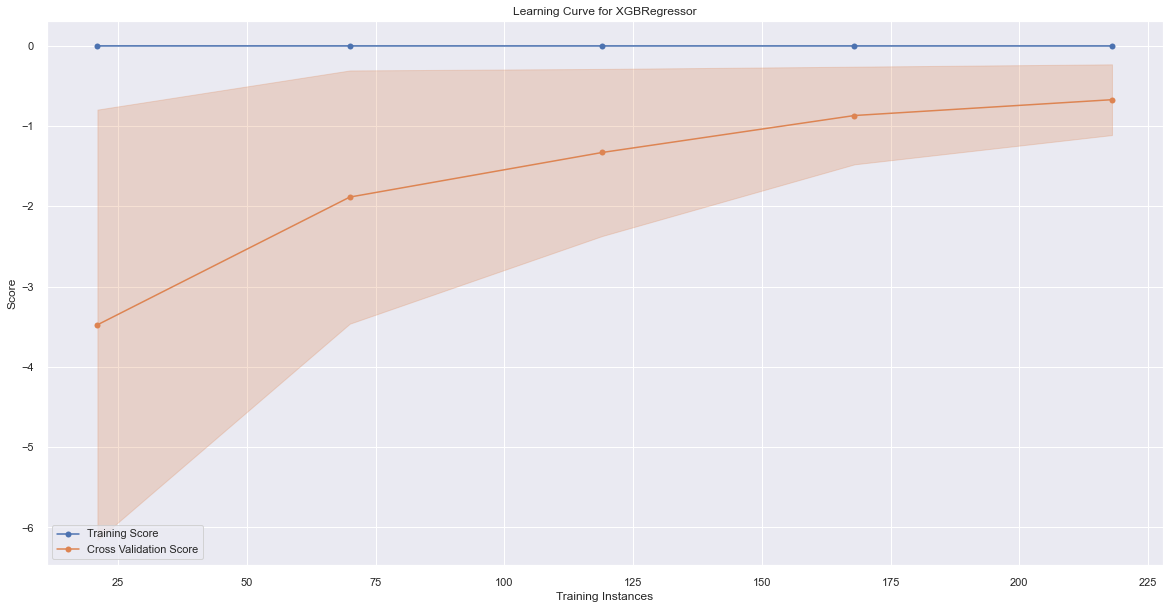

In [231]:
fwi_fitted_models["XGBRegressor"].evaluate_model(type="reg", plot_learning_curve=True)

We see that the XGBRegressor is overfititng with there being a high variance. We'll try to deal with this by reducing the amount of features and removing the highly correlated features.

In [232]:
# Removing highly correlated variables.
forest_fires_fwi.remove_highly_corr(exclude=["BUI", "Temperature"])

           correlation
RH   FFMC     0.644873
     ISI      0.686667
FFMC RH       0.644873
     DMC      0.603608
     ISI      0.740007
DMC  FFMC     0.603608
     DC       0.875925
     ISI      0.680454
DC   DMC      0.875925
ISI  RH       0.686667
     FFMC     0.740007
     DMC      0.680454


,day,month,Temperature,Ws,Rain,BUI
0,1,6,29,18,0.0,3.4
1,2,6,29,13,1.3,3.9
2,3,6,26,22,13.1,2.7
3,4,6,25,13,2.5,1.7
4,5,6,27,16,0.0,3.9
...,...,...,...,...,...,...
238,26,9,30,14,0.0,16.9
239,27,9,28,15,4.4,6.2
240,28,9,27,29,0.5,3.4
241,29,9,24,18,0.1,5.1


In [233]:
fwi_models = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()]
fwi_fitted_models = {}
fwi_feature_importances = {}
fwi_model_scores = pd.DataFrame(index=["R2", "MAE", "MSE"])

for model in fwi_models:
    m = Model(forest_fires_fwi.target_var, forest_fires_fwi.df_clean, model)
    m.evaluate_model(type="reg", plot_learning_curve=False)
    fwi_fitted_models[m.model_name] = m
    fwi_feature_importances[m.model_name] = m.model.feature_importances_
    fwi_model_scores = pd.merge(fwi_model_scores, m.scores, left_index=True, right_index=True)

X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [ 7.1  5.9  0.3  5.9 19.3]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.3
Mean Absolute Error: 3.0
Mean Squared Error: 21.0
X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [ 9.261  5.534  0.288 10.734 11.247]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.8
Mean Absolute Error: 2.0
Mean Squared Error: 6.0
X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [7.5397377  5.5693836  0.29891565 8.714728   9.9147005 ]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.76
Mean Absolute Error: 2.0
Mean Squared Error: 7.0


In [234]:
fwi_model_scores

,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor
R2,0.296437,0.796607,0.760776
MAE,2.614286,1.712878,1.844845
MSE,21.323878,6.164529,7.250499


X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [ 9.196  5.737  0.306 10.116 11.266]
first five actual values: [8.4, 7.2, 0.5, 3.8, 6.5]
R2: 0.81
Mean Absolute Error: 2.0
Mean Squared Error: 6.0
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_w

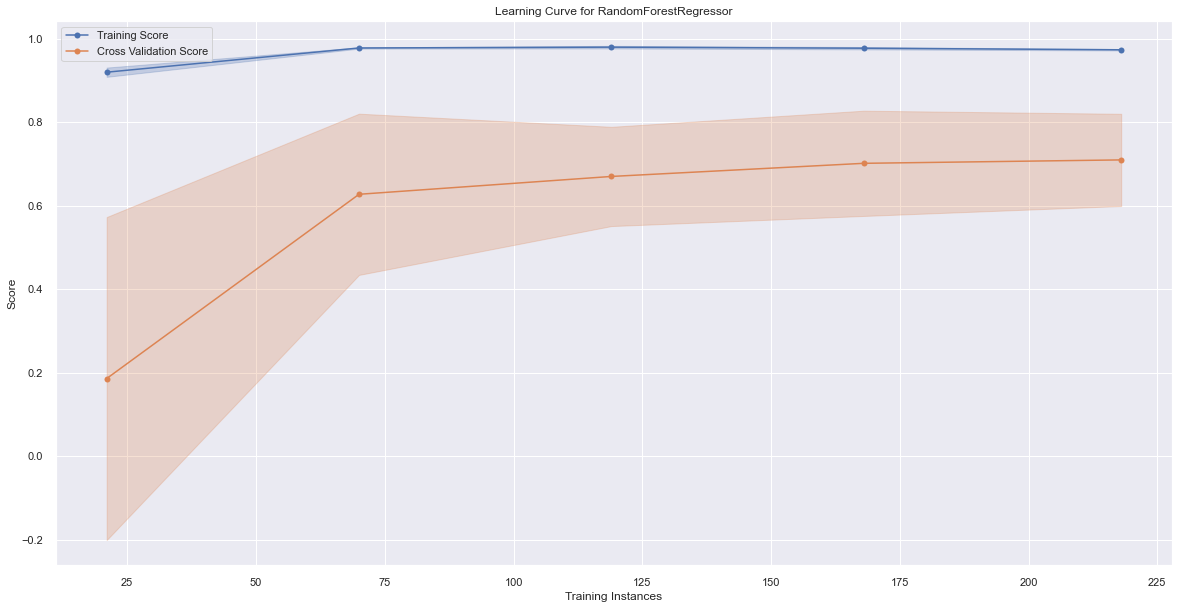

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha

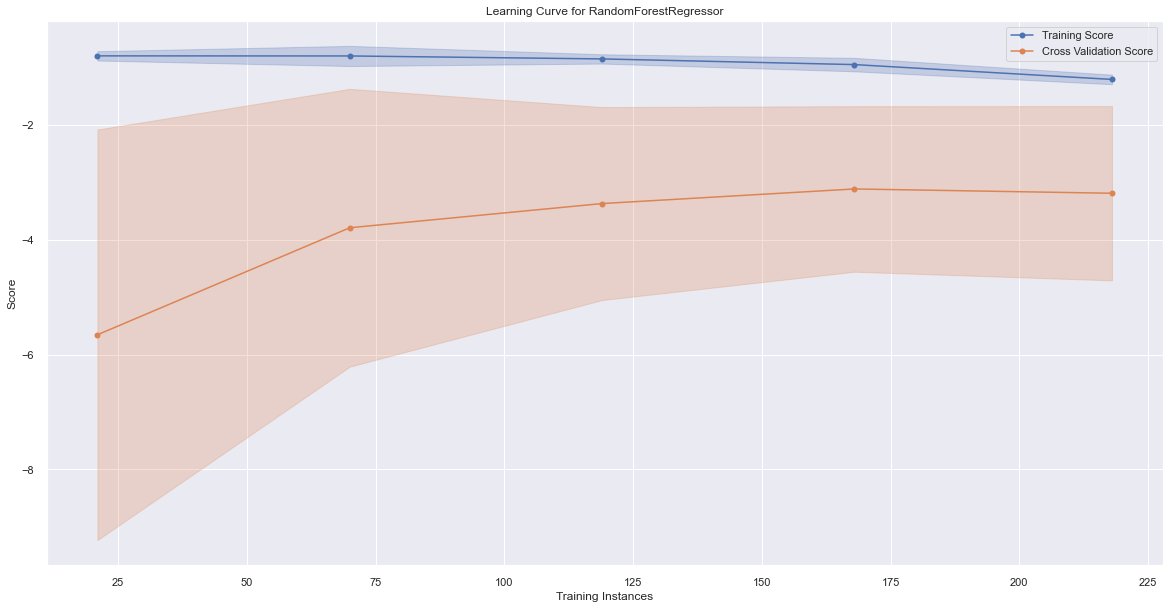

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha

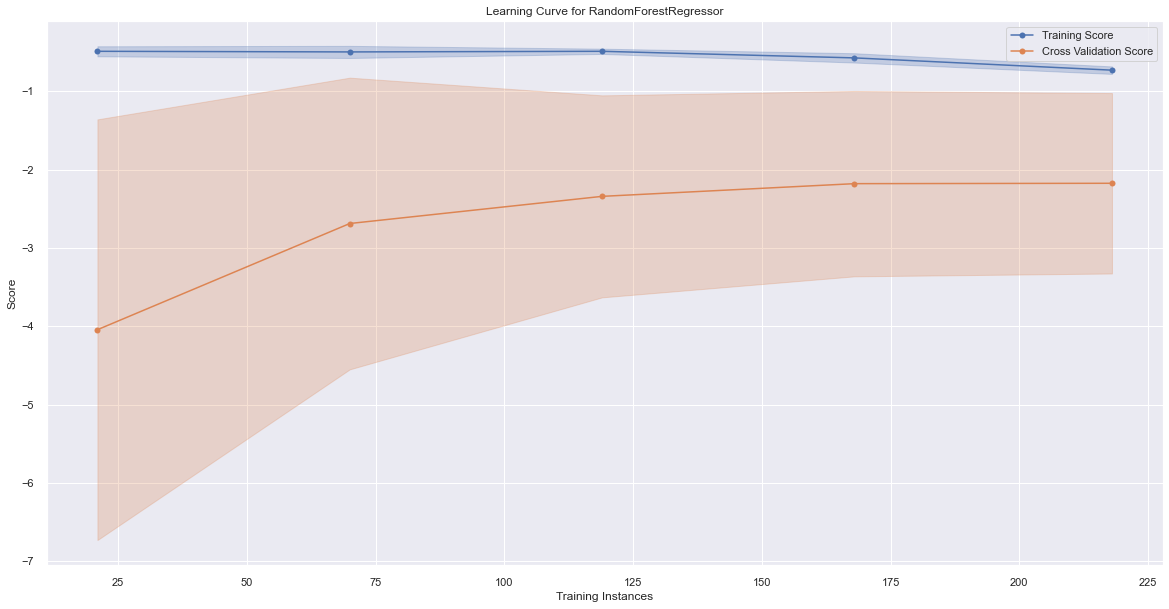

In [235]:
fwi_fitted_models["RandomForestRegressor"].evaluate_model(type="reg", plot_learning_curve=True)

By reducing the amount of features we see some reduction in variance and overfit.

## Classes

In [236]:
classes_models = [DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]
classes_fitted_models = {}
classes_feature_importances = {}
classes_model_scores = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])

for model in classes_models:
    m = Model(forest_fires_classes.target_var, forest_fires_classes.df_clean, model)
    m.evaluate_model(type="class", plot_learning_curve=False)
    classes_fitted_models[m.model_name] = m
    classes_feature_importances[m.model_name] = m.model.feature_importances_
    classes_model_scores = pd.merge(classes_model_scores, m.scores, left_index=True, right_index=True)

X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 0 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 0 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
[08:56:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
first five predicted values: [1 1 0 0 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.9591836734693877
Precision: 0.9629629629629629
Recall: 0.9629629629629629
F1: 0.9629629629629629


c:\Users\terje\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



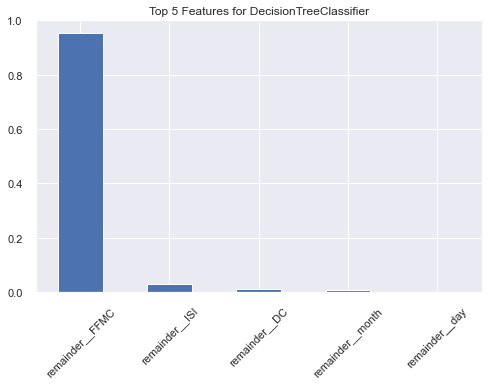

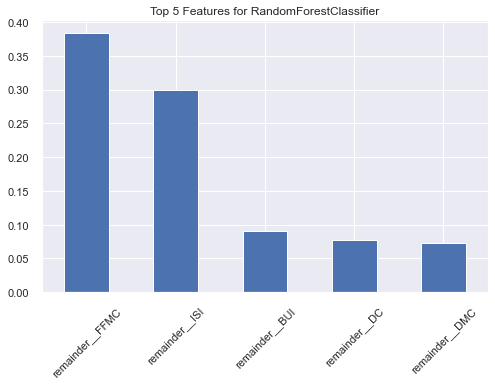

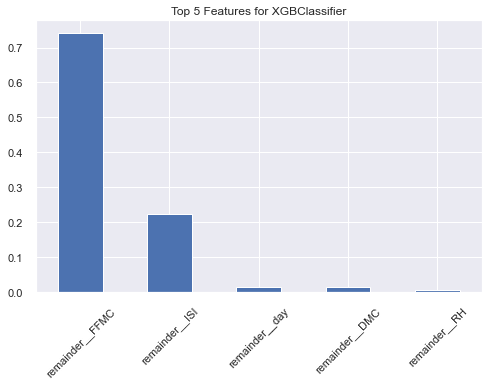

In [237]:
for model in classes_fitted_models.values():
    model.feature_importance_plot()

In [238]:
classes_model_scores.sort_index(ascending=False)

,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier
Recall,1.0,1.0,0.962963
Precision,1.0,1.0,0.962963
F1,1.0,1.0,0.962963
Accuracy,1.0,1.0,0.959184


X_train shape (194, 11)
X_test shape (49, 11)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 0 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.9795918367346939
Precision: 1.0
Recall: 0.9629629629629629
F1: 0.9811320754716981
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples

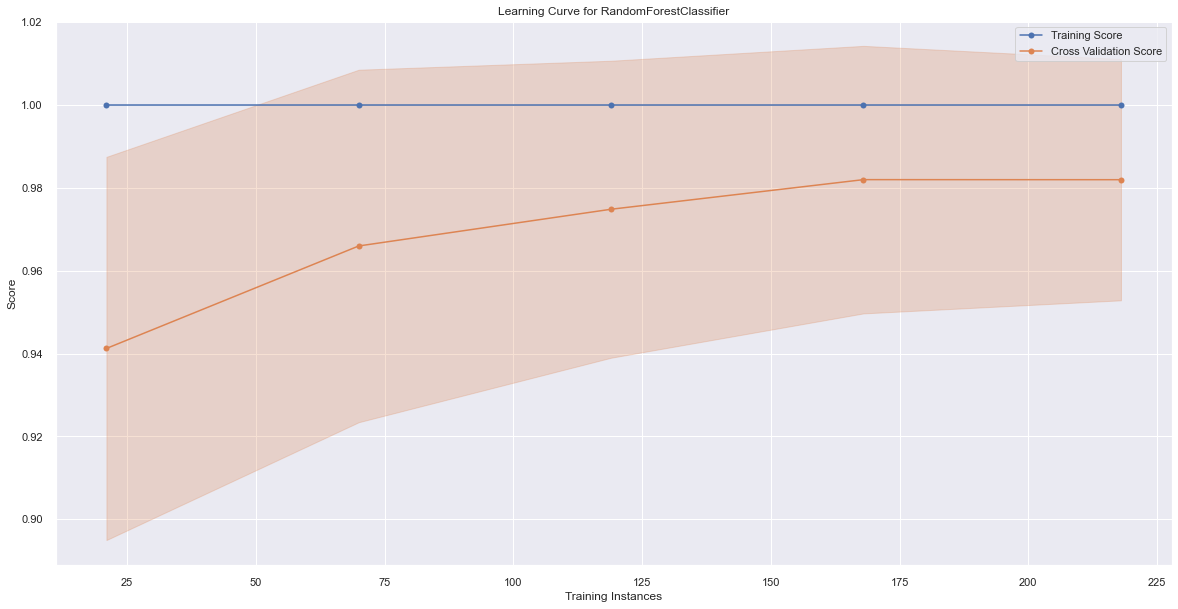

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train

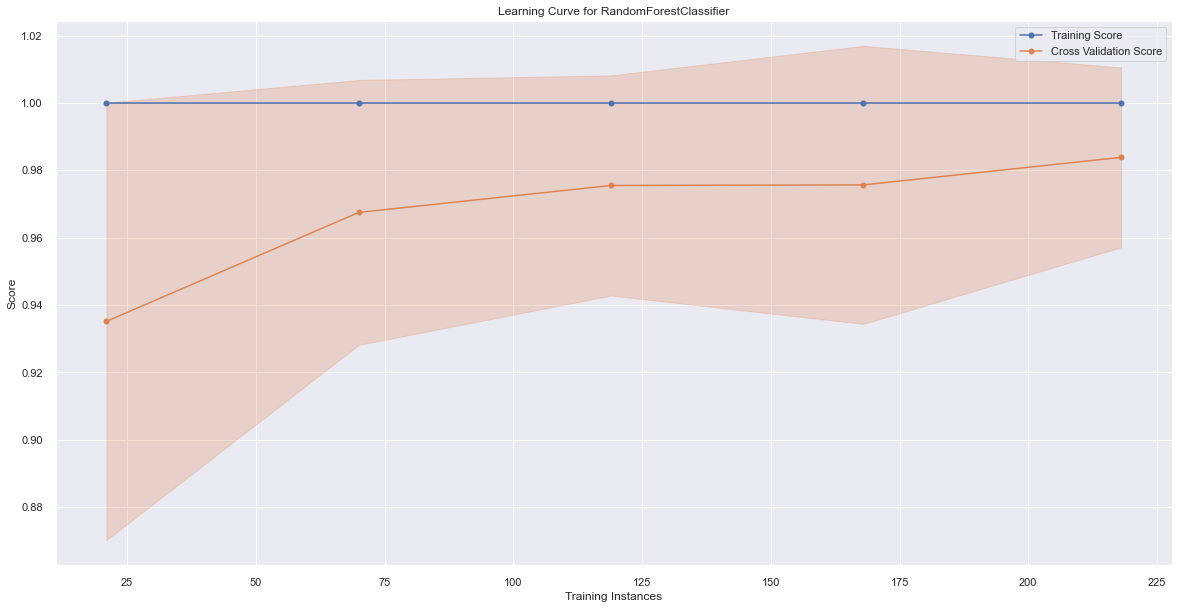

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train

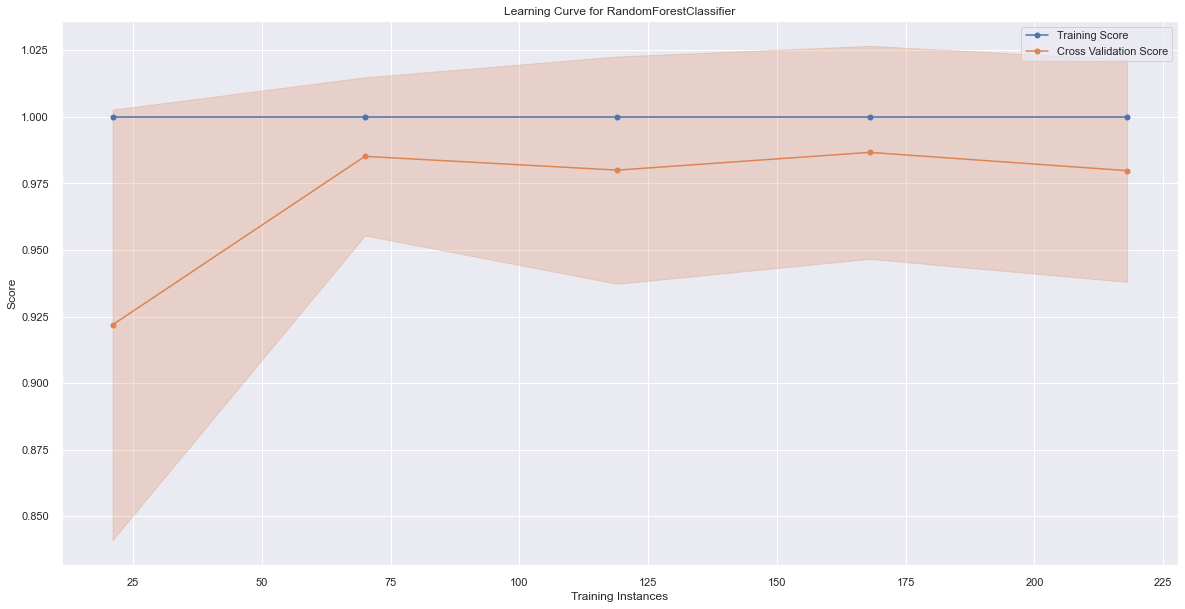

In [239]:
classes_fitted_models["RandomForestClassifier"].evaluate_model(type="cat", plot_learning_curve=True)

In [240]:
forest_fires_classes.remove_highly_corr(exclude=["BUI", "Temperature"])

           correlation
RH   FFMC     0.644873
     ISI      0.686667
FFMC RH       0.644873
     DMC      0.603608
     ISI      0.740007
DMC  FFMC     0.603608
     DC       0.875925
     ISI      0.680454
DC   DMC      0.875925
ISI  RH       0.686667
     FFMC     0.740007
     DMC      0.680454


,day,month,Temperature,Ws,Rain,BUI
0,1,6,29,18,0.0,3.4
1,2,6,29,13,1.3,3.9
2,3,6,26,22,13.1,2.7
3,4,6,25,13,2.5,1.7
4,5,6,27,16,0.0,3.9
...,...,...,...,...,...,...
238,26,9,30,14,0.0,16.9
239,27,9,28,15,4.4,6.2
240,28,9,27,29,0.5,3.4
241,29,9,24,18,0.1,5.1


In [241]:
classes_models = [DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]
classes_fitted_models = {}
classes_feature_importances = {}
classes_model_scores = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])

for model in classes_models:
    m = Model(forest_fires_classes.target_var, forest_fires_classes.df_clean, model)
    m.evaluate_model(type="class", plot_learning_curve=False)
    classes_fitted_models[m.model_name] = m
    classes_feature_importances[m.model_name] = m.model.feature_importances_
    classes_model_scores = pd.merge(classes_model_scores, m.scores, left_index=True, right_index=True)

X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 0 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.8367346938775511
Precision: 0.9130434782608695
Recall: 0.7777777777777778
F1: 0.84
X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 1 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.8367346938775511
Precision: 0.8518518518518519
Recall: 0.8518518518518519
F1: 0.8518518518518519
X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
[08:56:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
first five predicted values: [1 1 0 0 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.8367346938775511
Precision: 0.9

c:\Users\terje\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



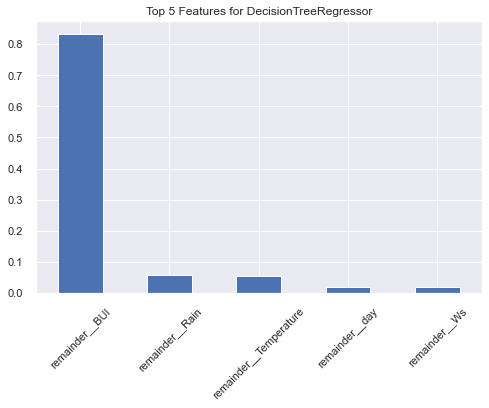

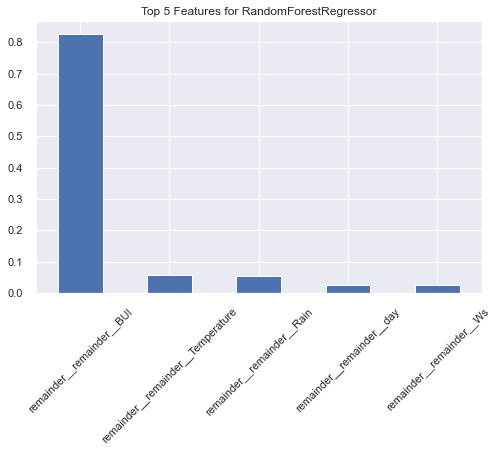

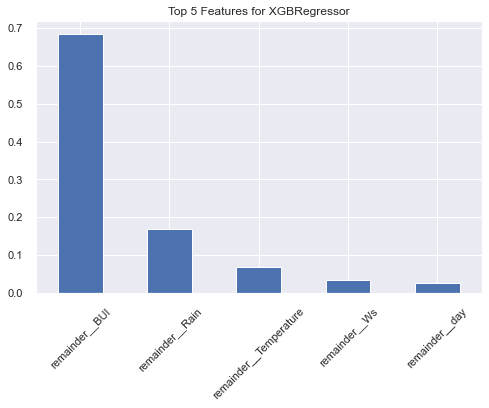

In [242]:
for model in fwi_fitted_models.values():
    model.feature_importance_plot()

In [243]:
classes_model_scores

,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier
Accuracy,0.836735,0.836735,0.836735
Precision,0.913043,0.851852,0.913043
Recall,0.777778,0.851852,0.777778
F1,0.840000,0.851852,0.840000


Seeing as the RandomForest model has the highest Recall it this seems to be the most optimal.

X_train shape (194, 6)
X_test shape (49, 6)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 1 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.8367346938775511
Precision: 0.88
Recall: 0.8148148148148148
F1: 0.8461538461538461
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_

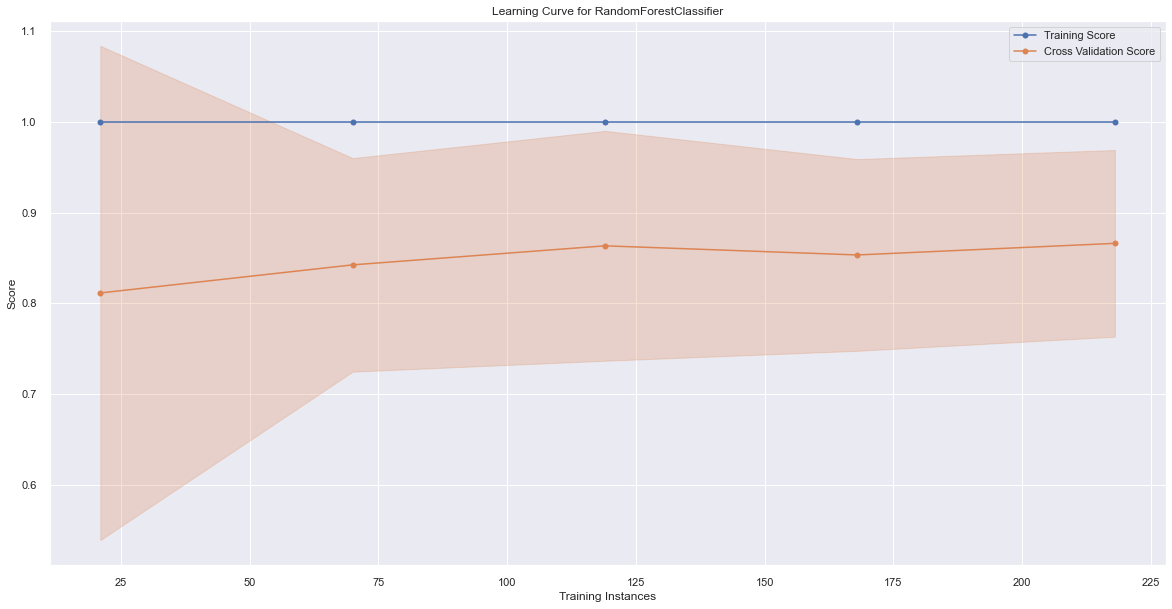

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train

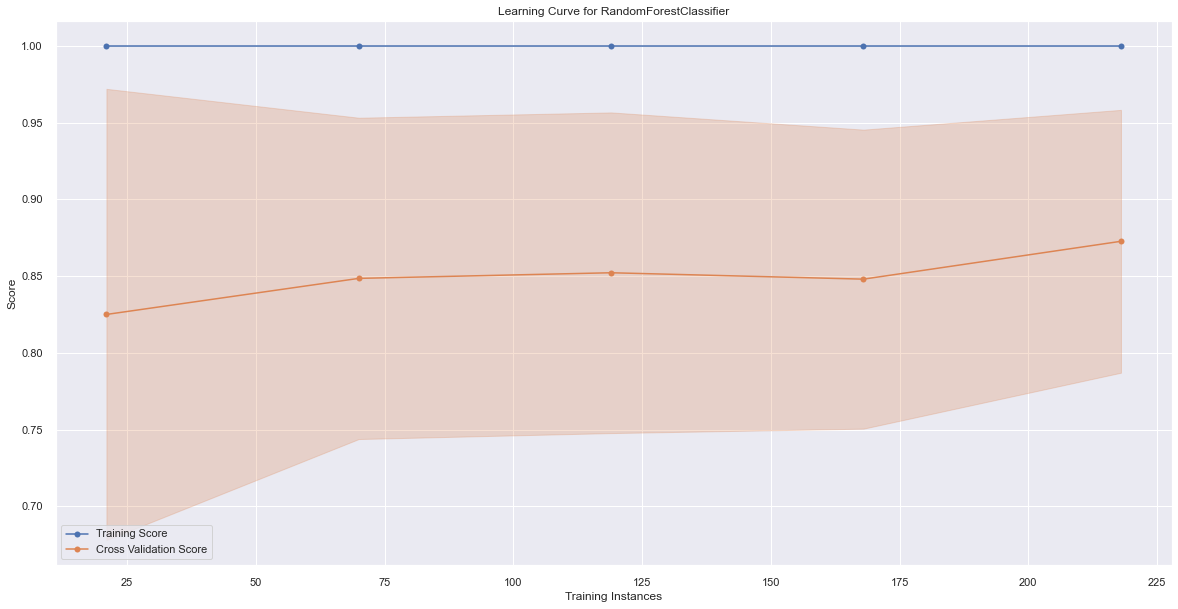

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train

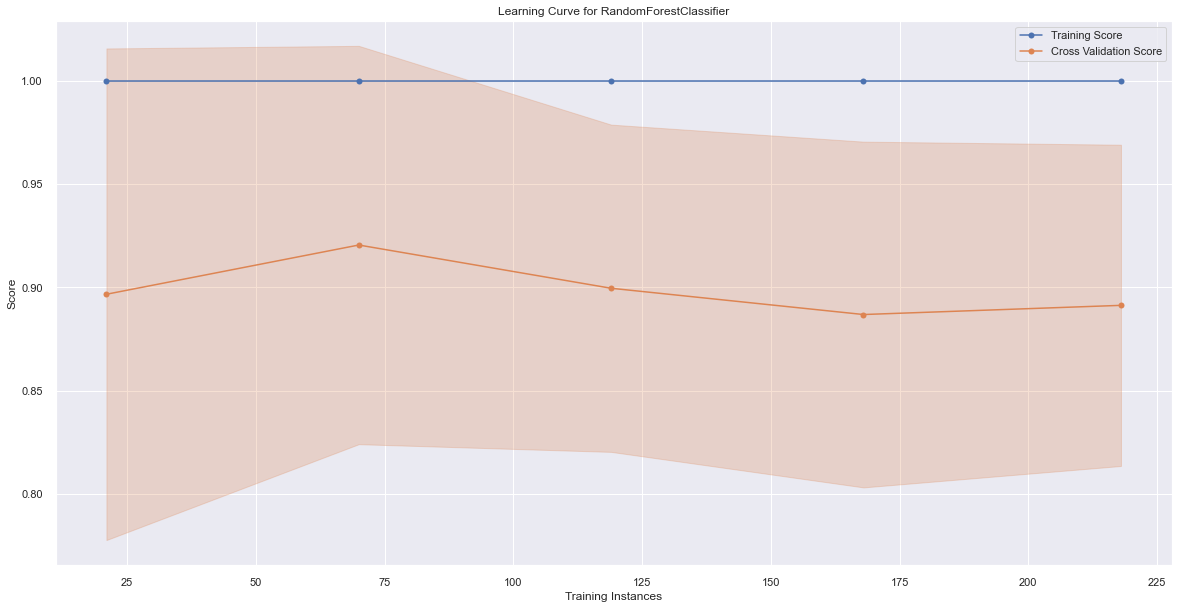

In [244]:
classes_fitted_models["RandomForestClassifier"].evaluate_model(type="cat", plot_learning_curve=True)